# The Following Work is solely for FDL course.

Zhenning Li has the sole property right on it.

More details please go to https://github.com/handsomevictor/data_science_projects_done

In [1]:
import torch.nn as nn
import torch
from torch import cuda
import cv2
import os
import glob
from torch.utils.data import Dataset
import random
from torchvision import transforms
import matplotlib.pyplot as plt
from torch import optim
from tqdm import tqdm
import numpy as np
from torchvision.utils import save_image
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn


import warnings
warnings.filterwarnings("ignore") 

In [2]:
if cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
device

'cuda'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Shape Image to a lower size

### Create path

In [4]:
# 判断文件夹是否存在，不存在就创建
def create_dir_not_exist(path):
    if not os.path.exists(path):
        os.mkdir(path)
        print('path created!')
    else:
        print('path already there!')

new_file_path_train_data = '/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/train_images/train_images_resized'
new_file_path_train_label = '/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/train_masks/train_masks_resized'

create_dir_not_exist(new_file_path_train_data)
create_dir_not_exist(new_file_path_train_label)

path already there!
path already there!


### Resize the image to squared one (use the larger one between width and height to crop the image and resize them to 256*256)

In [5]:
# 由于图片不是正方形，所以先把图片做成正方形。这里
def Square_Generated_and_saved(read_file, target_file_copy=False, colorful=True, show_image=False, do_it_questionmark=False): # 这个不需要直接传tensor格式！
    if do_it_questionmark:
    
        image = Image.open(read_file)
        w, h = image.size
        # print(w,h)

        if colorful:
            new_image = Image.new('RGB', size=(max(w, h), max(w, h)),color= 'white')
        else:
            new_image = Image.new('L', size=(max(w, h), max(w, h)),color= 'white')

        # print(background)
        length = int(abs(w - h))
        box = (length, 0) if w < h else (0, length)
        new_image.paste(image, box)
        
        new_image=new_image.resize((256,256)) # 这个如果之后太慢的话再加

        if target_file_copy:
            # 提取文件名字
            image_name = read_file.split('/')[-1]
            target_file_copy = target_file_copy + '/' + image_name
            new_image.save(target_file_copy)

        if show_image:
            return new_image # 不是tensor格式！需要再用image_to_tensor！
        else:
            return None
    
    else:
        print('The images in this dir have already been resized and saved!')

### Have a look

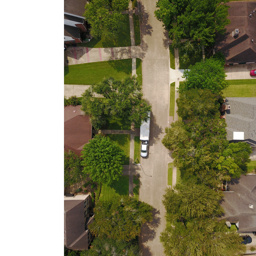

In [11]:
Square_Generated_and_saved('/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/train_images/train_images/10172.jpg', target_file_copy=new_file_path_train_data, colorful=True, show_image=True, do_it_questionmark=True)

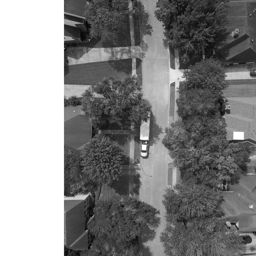

In [12]:
Square_Generated_and_saved('/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/train_images/train_images/10172.jpg', target_file_copy=new_file_path_train_data, colorful=False, show_image=True, do_it_questionmark=True)

In [ ]:
# Firstly let's reshape every image we have and store them in another file
import glob
import os
from tqdm import tqdm

train_data_path = '/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/train_images/train_images'
train_mask_path = '/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/train_masks/train_masks'

imgs_path = glob.glob(os.path.join(train_data_path, '*.jpg'))
mask_path = glob.glob(os.path.join(train_mask_path, '*.png'))

for image_file in tqdm(imgs_path):
    Square_Generated_and_saved(image_file, new_file_path_train_data, colorful=True, show_image=False, do_it_questionmark=False)
for image_file in tqdm(mask_path):
    Square_Generated_and_saved(image_file, new_file_path_train_label, colorful=False, show_image=False, do_it_questionmark=False)

## Resize the test image data

In [6]:
# 我们得把test image resize成256再说
def make_test_image_resized(necessary=False):
    if necessary:
        create_dir_not_exist('/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/test_images/test_images_resized')
        test_data_path = '/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/test_images/test_images_resized'
        test_path_for_pred = glob.glob(os.path.join(test_data_path, '*.jpg'))

        for test_ in tqdm(test_path):
            Square_Generated_and_saved(test_, target_file_copy=test_data_path, colorful=True, show_image=False)
    else:
        print('Nothing is excecuted since the test images are already resized!')

In [34]:
# Here if you want to rerun my model, please change this parameter to True and change the dir accordingly!
make_test_image_resized(necessary=False)

Nothing is excecuted since the test images are already resized!


# Building each layer in the model

## DoubleConv Class

In [7]:
# first model part
class DoubleConv(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), # 这里我们让padding=1，也就是图片大小不变
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        return self.double_conv(x)

## Down Class

In [8]:
class Down(nn.Module):
 
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),                            # 等于每次图片缩小一半
            DoubleConv(in_channels, out_channels)
        )
 
    def forward(self, x):
        return self.maxpool_conv(x)

## Up Class

In [9]:
class Up(nn.Module):
 
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
 
        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2) # 这里我们让第一个参数依然除以2也就是图片大小不变
 
        self.conv = DoubleConv(in_channels, out_channels)
 
    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = torch.tensor([x2.size()[2] - x1.size()[2]])
        diffX = torch.tensor([x2.size()[3] - x1.size()[3]])
 
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

## OutConv Class


In [10]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
 
    def forward(self, x):
        return self.conv(x)

# Define Dice Loss

In [11]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

# Prepare DataLoader

In [12]:
class ISBI_Loader(Dataset):
    def __init__(self, train_data_path, train_mask_path):
        # 初始化函数，读取所有data_path下的图片
        self.train_data_path = train_data_path
        self.train_mask_path = train_mask_path
        self.imgs_path = glob.glob(os.path.join(train_data_path, '*.jpg'))
        self.mask_path = glob.glob(os.path.join(train_mask_path, '*.png'))
        
    def augment(self, image, flipCode):
        # 使用cv2.flip进行数据增强，filpCode为1水平翻转，0垂直翻转，-1水平+垂直翻转
        flip = cv2.flip(image, flipCode)
        return flip
        
    def __getitem__(self, index):
        # 根据index读取图片
        data_path = self.imgs_path[index]
        mask_path = self.mask_path[index]
        
        # 读取训练图片和标签图片
        image = cv2.imread(data_path)
        label = cv2.imread(mask_path, 0) # use 0 to set the image into grey mode

        # 这里必须处理一下，一定要Normalize到0-1之间
        # print(label.max())
        if label.max() > 1:
            label = label / 255
        if image.max() > 1:
            image = image / 255
            
        # 随机进行数据增强，为2时不做处理
        flipCode = random.choice([-1, 0, 1, 2])
        if flipCode != 2:
            image = self.augment(image, flipCode)
            label = self.augment(label, flipCode)
            
        # 这里需要处理一下数据，把每个图片的feature数量放到第一位
        image = torch.tensor(image)
        image = image.permute(2, 0, 1)
        label = torch.tensor(label)
        # label = label.unsqueeze(0)
        # print(label.shape)
        # label = label.permute(2, 0, 1)
                
        return image.numpy(), label.numpy()
 
    def __len__(self):
        # 返回训练集大小
        return len(self.imgs_path)


# 这里由于图片大小不一样，为了test模型，我们先把batch_size设定为1，之后如果可以运行再设定为2或以上
if __name__ == "__main__":
    isbi_dataset = ISBI_Loader('/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/train_images/train_images', '/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/train_masks/train_masks')
    print("数据个数：", len(isbi_dataset))
    train_loader = torch.utils.data.DataLoader(dataset=isbi_dataset,
                                               batch_size=1, 
                                               shuffle=True)

数据个数： 261


# Model Building

In [13]:
# Check GPU condition
if device == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')
    
    # Clear GPU
    torch.cuda.empty_cache()

Tesla P100-PCIE-16GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [14]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)

        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        self.up1 = Up(1024, 512, bilinear)
        self.up2 = Up(512, 256, bilinear)
        self.up3 = Up(256, 128, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):

        x1 = self.inc(x)

        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [15]:
# Check shape
image = cv2.imread('/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/test_images/test_images/10170.jpg')
image = torch.tensor(image)
print(image.permute(2, 0, 1).shape)
image.permute(2, 0, 1).unsqueeze(0).shape

torch.Size([3, 4000, 3000])


torch.Size([1, 3, 4000, 3000])

In [16]:
# Check shape again
image = cv2.imread('/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/train_images/train_images_resized/10172.jpg')
image = torch.tensor(image)
image.permute(2, 0, 1).size()

torch.Size([3, 256, 256])

# Write the training function

In [17]:
def train_net(net, device, train_data_path, train_mask_path, model_save_file_name=True, model_name=True, mean_loss_file_name=True, loss_name=True, epochs=200, batch_size=4, lr=0.00001):
    # 加载训练集
    isbi_dataset = ISBI_Loader(train_data_path, train_mask_path)
    train_loader = torch.utils.data.DataLoader(dataset=isbi_dataset,
                                               batch_size=batch_size, 
                                               shuffle=True)
    # 定义RMSprop算法
    optimizer = optim.RMSprop(net.parameters(), lr=lr, weight_decay=1e-8, momentum=0.9)

    # 定义Loss算法
    criterion = nn.CrossEntropyLoss()
    
    # Here we don't first use Dice Loss, we have a try on other's loss
    # 这里先不用optim.Adam(net.parameters(), lr=0.00001)
    
    # best_loss统计，初始化为正无穷
    # best_loss = float('inf')

    train_data_mean_loss = []
    device = 'cuda'
    for epoch in range(epochs):
        net.train()
        print('Epoch ', epoch, 'starts!')
        # 仅用来记录每一次的loss，最后求平均放到train_data_mean_loss中
        train_data_loss_each_epoch = []

        for image, label in tqdm(train_loader):
            optimizer.zero_grad()

            image = image.to(device=device, dtype=torch.float32)
            label = label.to(device=device, dtype=torch.float32)

            pred = net(image)

            label = label.type(torch.LongTensor)

            pred = pred.to(device)
            label = label.to(device)  # 这个不知道为什么不加这一句的话直接会用cpu来跑

            loss = criterion(pred, label)
            train_data_loss_each_epoch.append(loss.item())

            # 保存loss值最小的网络参数
            # if loss < best_loss:
            #     best_loss = loss
            #     torch.save(net.state_dict(), 'best_model.pth')
            loss.backward()
            optimizer.step()

        train_data_mean_loss.append(np.mean(train_data_loss_each_epoch))
    
    # -----------------Model Save-----------------
    create_dir_not_exist(model_save_file_name)
    final_name_for_model = model_save_file_name + '/' + model_name
    torch.save(net.state_dict(), final_name_for_model)
    print('model saved successfully!')

    # -----------------Loss List Save-----------------------
    create_dir_not_exist(mean_loss_file_name)
    train_data_mean_loss = np.array(train_data_mean_loss)
    final_name_for_loss = mean_loss_file_name + '/' + loss_name
    np.save(final_name_for_loss, train_data_mean_loss)
    print('mean loss saved successfully!')


# Try first time training with epoch=4, batch_size=2

In [21]:
if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_data_path = '/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/train_images/train_images_resized'
    train_mask_path = '/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/train_masks/train_masks_resized'
    model_save_file_name = '/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/saved_model_and_loss'
    model_name = 'Model_256_epochs5_batch_size2_lr000001_Jan17_for_report.pt'
    mean_loss_file_name = model_save_file_name
    loss_name = 'Mean_loss_256_epochs5_batch_size2_lr000001_Jan17_for_report.npy'

    net = UNet(n_channels=3, n_classes=25)
    net.to(device='cuda')
    train_net(net,
              device, 
              train_data_path=train_data_path, 
              train_mask_path=train_mask_path, 
              model_save_file_name=model_save_file_name, 
              model_name=model_name, 
              mean_loss_file_name=mean_loss_file_name, 
              loss_name=loss_name, 
              epochs=4, 
              batch_size=10, 
              lr=0.00001)

Epoch  0 starts!


100%|██████████| 27/27 [01:20<00:00,  2.97s/it]


Epoch  1 starts!


100%|██████████| 27/27 [00:10<00:00,  2.59it/s]


Epoch  2 starts!


100%|██████████| 27/27 [00:10<00:00,  2.58it/s]


Epoch  3 starts!


100%|██████████| 27/27 [00:10<00:00,  2.58it/s]


path already there!
model saved successfully!
path already there!
mean loss saved successfully!


## See the loss function value trend of this model

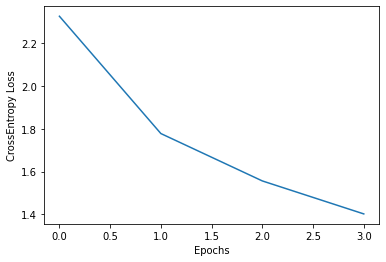

In [22]:
# 现在读取一下刚跑完的模型的loss看看图像如何
model_save_file_name = '/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/saved_model_and_loss'
loss_name = 'Mean_loss_256_epochs5_batch_size2_lr000001_Jan17_for_report.npy'
epoch_train_loss_filename = model_save_file_name + '/' + loss_name

train_data_mean_loss = np.load(epoch_train_loss_filename)
plt.plot(train_data_mean_loss, label ='Train Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.show()

Seems the model is training indeed, now let's change epochs to find the best point.

## Train another time, select epochs = 50, and batch_size = 4

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_data_path = '/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/train_images/train_images_resized'
train_mask_path = '/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/train_masks/train_masks_resized'
model_save_file_name = '/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/saved_model_and_loss'
model_name = 'Model_256_epochs50_batch_size4_lr000001_Jan17_for_report.pt'
mean_loss_file_name = model_save_file_name
loss_name = 'Mean_loss_256_epochs50_batch_size4_lr000001_Jan17_for_report.npy'

net = UNet(n_channels=3, n_classes=25)
net.to(device=device)
train_net(net,
          device, 
          train_data_path=train_data_path, 
          train_mask_path=train_mask_path, 
          model_save_file_name=model_save_file_name, 
          model_name=model_name, 
          mean_loss_file_name=mean_loss_file_name, 
          loss_name=loss_name, 
          epochs=50, 
          batch_size=4, 
          lr=0.0001)

Epoch  0 starts!


100%|██████████| 66/66 [00:10<00:00,  6.49it/s]


Epoch  1 starts!


100%|██████████| 66/66 [00:10<00:00,  6.52it/s]


Epoch  2 starts!


100%|██████████| 66/66 [00:10<00:00,  6.52it/s]


Epoch  3 starts!


100%|██████████| 66/66 [00:10<00:00,  6.52it/s]


Epoch  4 starts!


100%|██████████| 66/66 [00:10<00:00,  6.53it/s]


Epoch  5 starts!


100%|██████████| 66/66 [00:10<00:00,  6.52it/s]


Epoch  6 starts!


100%|██████████| 66/66 [00:10<00:00,  6.52it/s]


Epoch  7 starts!


100%|██████████| 66/66 [00:10<00:00,  6.52it/s]


Epoch  8 starts!


100%|██████████| 66/66 [00:10<00:00,  6.52it/s]


Epoch  9 starts!


100%|██████████| 66/66 [00:10<00:00,  6.52it/s]


Epoch  10 starts!


100%|██████████| 66/66 [00:10<00:00,  6.52it/s]


Epoch  11 starts!


100%|██████████| 66/66 [00:10<00:00,  6.52it/s]


Epoch  12 starts!


100%|██████████| 66/66 [00:10<00:00,  6.52it/s]


Epoch  13 starts!


100%|██████████| 66/66 [00:10<00:00,  6.52it/s]


Epoch  14 starts!


100%|██████████| 66/66 [00:10<00:00,  6.52it/s]


Epoch  15 starts!


100%|██████████| 66/66 [00:10<00:00,  6.52it/s]


Epoch  16 starts!


100%|██████████| 66/66 [00:10<00:00,  6.53it/s]


Epoch  17 starts!


100%|██████████| 66/66 [00:10<00:00,  6.52it/s]


Epoch  18 starts!


100%|██████████| 66/66 [00:10<00:00,  6.52it/s]


Epoch  19 starts!


100%|██████████| 66/66 [00:10<00:00,  6.52it/s]


Epoch  20 starts!


100%|██████████| 66/66 [00:10<00:00,  6.52it/s]


Epoch  21 starts!


100%|██████████| 66/66 [00:10<00:00,  6.52it/s]


Epoch  22 starts!


100%|██████████| 66/66 [00:10<00:00,  6.51it/s]


Epoch  23 starts!


100%|██████████| 66/66 [00:10<00:00,  6.52it/s]


Epoch  24 starts!


100%|██████████| 66/66 [00:10<00:00,  6.51it/s]


Epoch  25 starts!


100%|██████████| 66/66 [00:10<00:00,  6.51it/s]


Epoch  26 starts!


100%|██████████| 66/66 [00:10<00:00,  6.52it/s]


Epoch  27 starts!


100%|██████████| 66/66 [00:10<00:00,  6.52it/s]


Epoch  28 starts!


100%|██████████| 66/66 [00:10<00:00,  6.53it/s]


Epoch  29 starts!


100%|██████████| 66/66 [00:10<00:00,  6.52it/s]


Epoch  30 starts!


100%|██████████| 66/66 [00:10<00:00,  6.52it/s]


Epoch  31 starts!


100%|██████████| 66/66 [00:10<00:00,  6.53it/s]


Epoch  32 starts!


100%|██████████| 66/66 [00:10<00:00,  6.53it/s]


Epoch  33 starts!


100%|██████████| 66/66 [00:10<00:00,  6.53it/s]


Epoch  34 starts!


100%|██████████| 66/66 [00:10<00:00,  6.53it/s]


Epoch  35 starts!


100%|██████████| 66/66 [00:10<00:00,  6.53it/s]


Epoch  36 starts!


100%|██████████| 66/66 [00:10<00:00,  6.53it/s]


Epoch  37 starts!


100%|██████████| 66/66 [00:10<00:00,  6.53it/s]


Epoch  38 starts!


100%|██████████| 66/66 [00:10<00:00,  6.53it/s]


Epoch  39 starts!


100%|██████████| 66/66 [00:10<00:00,  6.47it/s]


Epoch  40 starts!


100%|██████████| 66/66 [00:10<00:00,  6.52it/s]


Epoch  41 starts!


100%|██████████| 66/66 [00:10<00:00,  6.53it/s]


Epoch  42 starts!


100%|██████████| 66/66 [00:10<00:00,  6.52it/s]


Epoch  43 starts!


100%|██████████| 66/66 [00:10<00:00,  6.53it/s]


Epoch  44 starts!


100%|██████████| 66/66 [00:10<00:00,  6.52it/s]


Epoch  45 starts!


100%|██████████| 66/66 [00:10<00:00,  6.52it/s]


Epoch  46 starts!


100%|██████████| 66/66 [00:10<00:00,  6.53it/s]


Epoch  47 starts!


100%|██████████| 66/66 [00:10<00:00,  6.52it/s]


Epoch  48 starts!


100%|██████████| 66/66 [00:10<00:00,  6.52it/s]


Epoch  49 starts!


100%|██████████| 66/66 [00:10<00:00,  6.52it/s]


path already there!
model saved successfully!
path already there!
mean loss saved successfully!


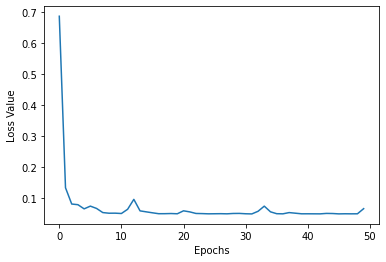

In [27]:
# 现在读取一下刚跑完的模型的loss看看图像如何
model_save_file_name = '/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/saved_model_and_loss'
loss_name = 'Mean_loss_256_epochs50_batch_size4_lr000001_Jan17_for_report.npy'
epoch_train_loss_filename = model_save_file_name + '/' + loss_name

train_data_mean_loss = np.load(epoch_train_loss_filename)
plt.plot(train_data_mean_loss, label ='Train Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.show()

## This loss graph clearly show that my model is seriously overfitting, so I still have to use train and validation dataloader to find the best epochs :( But here let me just choose epoch to be 23

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_data_path = '/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/train_images/train_images_resized'
train_mask_path = '/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/train_masks/train_masks_resized'
model_save_file_name = '/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/saved_model_and_loss'
model_name = 'Model_256_epochs23_batch_size4_lr00001_Jan17_for_report.pt'
mean_loss_file_name = model_save_file_name
loss_name = 'Mean_loss_256_epochs23_batch_size4_lr00001_Jan17_for_report.npy'

net = UNet(n_channels=3, n_classes=25)
net.to(device=device)
train_net(net,
          device, 
          train_data_path=train_data_path, 
          train_mask_path=train_mask_path, 
          model_save_file_name=model_save_file_name, 
          model_name=model_name, 
          mean_loss_file_name=mean_loss_file_name, 
          loss_name=loss_name, 
          epochs=23, 
          batch_size=4, 
          lr=0.0001)

Epoch  0 starts!


100%|██████████| 66/66 [00:10<00:00,  6.44it/s]


Epoch  1 starts!


100%|██████████| 66/66 [00:10<00:00,  6.54it/s]


Epoch  2 starts!


100%|██████████| 66/66 [00:10<00:00,  6.54it/s]


Epoch  3 starts!


100%|██████████| 66/66 [00:10<00:00,  6.53it/s]


Epoch  4 starts!


100%|██████████| 66/66 [00:10<00:00,  6.53it/s]


Epoch  5 starts!


100%|██████████| 66/66 [00:10<00:00,  6.53it/s]


Epoch  6 starts!


100%|██████████| 66/66 [00:10<00:00,  6.54it/s]


Epoch  7 starts!


100%|██████████| 66/66 [00:10<00:00,  6.54it/s]


Epoch  8 starts!


100%|██████████| 66/66 [00:10<00:00,  6.53it/s]


Epoch  9 starts!


100%|██████████| 66/66 [00:10<00:00,  6.54it/s]


Epoch  10 starts!


100%|██████████| 66/66 [00:10<00:00,  6.54it/s]


Epoch  11 starts!


100%|██████████| 66/66 [00:10<00:00,  6.53it/s]


Epoch  12 starts!


100%|██████████| 66/66 [00:10<00:00,  6.53it/s]


Epoch  13 starts!


100%|██████████| 66/66 [00:10<00:00,  6.53it/s]


Epoch  14 starts!


100%|██████████| 66/66 [00:10<00:00,  6.52it/s]


Epoch  15 starts!


100%|██████████| 66/66 [00:10<00:00,  6.52it/s]


Epoch  16 starts!


100%|██████████| 66/66 [00:10<00:00,  6.52it/s]


Epoch  17 starts!


100%|██████████| 66/66 [00:10<00:00,  6.52it/s]


Epoch  18 starts!


100%|██████████| 66/66 [00:10<00:00,  6.52it/s]


Epoch  19 starts!


100%|██████████| 66/66 [00:10<00:00,  6.53it/s]


Epoch  20 starts!


100%|██████████| 66/66 [00:10<00:00,  6.53it/s]


Epoch  21 starts!


100%|██████████| 66/66 [00:10<00:00,  6.53it/s]


Epoch  22 starts!


100%|██████████| 66/66 [00:10<00:00,  6.52it/s]


path already there!
model saved successfully!
path already there!
mean loss saved successfully!


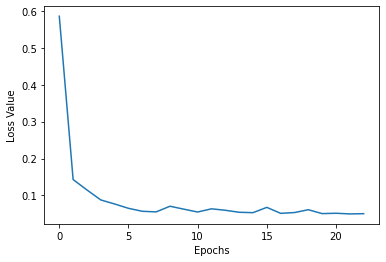

In [29]:
model_save_file_name = '/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/saved_model_and_loss'
loss_name = 'Mean_loss_256_epochs23_batch_size4_lr00001_Jan17_for_report.npy'
epoch_train_loss_filename = model_save_file_name + '/' + loss_name

train_data_mean_loss = np.load(epoch_train_loss_filename)
plt.plot(train_data_mean_loss, label ='Train Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.show()

Comment: The graph shows the model is indeed training, so now we try to make a prediction and have the first submission.

# Make predictions based on last model

## Read the model

In [30]:
model = UNet(n_channels=3, n_classes=25)
model.to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/saved_model_and_loss/Model_256_epochs23_batch_size4_lr00001_Jan17_for_report.pt'))

# Find test data
test_data_path = '/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/test_images/test_images'
test_path = glob.glob(os.path.join(test_data_path, '*.jpg'))

## Make sure the test images are correctly resized to 256*256

In [35]:
make_test_image_resized(necessary=False)

Nothing is excecuted since the test images are already resized!


# Start making predictions

In [36]:
# Start predicting
def pred_on_test(model, test_path_for_pred, model_save_dir): # 这两个参数都是文件夹位置，我们的目的是将新的图片保存下来！（不是保存tensor）

    for small_test_data in tqdm(test_path_for_pred):
        image = cv2.imread(small_test_data)

        if image.max() > 1:
            image = image / 255
        image = torch.tensor(image)
        image = image.permute(2, 0, 1)
        image = image.to(device=device, dtype=torch.float32)
        image = image.unsqueeze(0)

        model.eval()
        outputs = model(image) # 格式是tensor，大小是[1, 25, 256, 256]
        outputs = torch.argmax(outputs, 1) # 现在是[1, 256, 256]


        # -----------------------Save Pred Images------------------------
        image_name = small_test_data.split('/')[-1].split('.')[0]
        destination_dir = model_save_dir + '/' + image_name + '.png'
        outputs = outputs.long()

        if outputs.max() > 1:
            outputs = outputs.float()/255.0
        else:
            outputs = outputs.float()

        # outputs = outputs.float()
        save_image(outputs, destination_dir)  # outputs大小是[1, 256, 256]
        # save_image(torch.from_numpy(image_temp0).float()/255.0, './temp/0image_'+str(index_temp)+'.jpg', nrow= 1)

    print()
    print('Saved Successfully!')

test_data_path = '/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/test_images/test_images_resized'
test_path_for_pred = glob.glob(os.path.join(test_data_path, '*.jpg'))

model_save_dir = '/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/test_images/pred_small_test_images_256_epochs23_batch4_lr00001_Jan17_for_report'
create_dir_not_exist(model_save_dir)

pred_on_test(model, test_path_for_pred, model_save_dir=model_save_dir)

path created!


100%|██████████| 112/112 [00:04<00:00, 24.14it/s]


Saved Successfully!


## Now let's have a look at the predicted image, which is shit

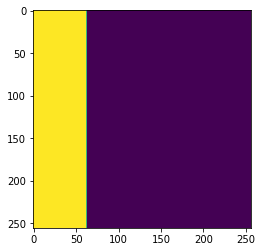

In [37]:
# 现在看一下预测出来的图片
dir = '/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/test_images/pred_small_test_images_256_epochs23_batch4_lr00001_Jan17_for_report'
imgs_path = glob.glob(os.path.join(dir, '*.png'))
mask = Image.open(imgs_path[1])
a = transforms.ToTensor()(mask)
plt.imshow(a[1].numpy())

So now the model we have only predicted 2 classes, which is not good at all.

# Define the resize function to make the predicted image back to its original size

This is not necessary, but I didn't find the resize back function in submission.py, so when I make my own pred images, I still resized them back. Here is the process

In [18]:
def resize_back(test_file, original_file, save_dir=True, show_image=False): 
    # 这里test_file就是预测出来的image, original_file是原本压缩前的image地址
    # save_dir仅仅为想要save这些图片的文件夹位置

    original_image = Image.open(original_file)
    test_small_image = Image.open(test_file)
    
    w, h = original_image.size
    # print(w,h)

    new_image = Image.new('L', size=(w, h), color= 'white')
    new_image = test_small_image.resize((w, h))

    # 将所有pixel都化成0-255之间
    # image = cv2.imread(small_test_data)

    if save_dir: # 意味着我们要保存这些图片
        # 提取文件名字
        image_name = test_file.split('/')[-1]
        save_dir = save_dir + '/' + str(image_name)
        new_image.save(save_dir)

    if show_image:
        return new_image # 不是tensor格式！需要再用image_to_tensor！
    else:
        return None

In [42]:
test_file = '/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/test_images/pred_small_test_images_256_epochs23_batch4_lr00001_Jan17_for_report'
original_file = '/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/test_images/test_images'

# ----------------------For saving new pred images-------------------------
create_dir_not_exist('/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/test_images/pred_small_test_images_resized_back_Jan17_for_report')
save_dir = '/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/test_images/pred_small_test_images_resized_back_Jan17_for_report'

test_files = glob.glob(os.path.join(test_file, '*.png'))
original_files = glob.glob(os.path.join(original_file, '*.jpg'))

path created!


In [43]:
# ---------------------Resize Back-------------------------
for i in tqdm(range(len(test_files))):
    resize_back(test_files[i], original_files[i], save_dir=save_dir, show_image=False)

100%|██████████| 112/112 [00:57<00:00,  1.94it/s]


# Prepare submission at the first trial

In [19]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

def create_rles():
    """Used for Kaggle submission: predicts and encode all test images"""
    # create_dir_not_exist('/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/submission')

    # -----------------------------Choose Dir------------------------------
    dir = '/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/test_images/pred_small_test_images_resized_back_Jan17_for_report/'

    N = len(list(os.listdir(dir)))
    with open('submission_file_first_trial.csv', 'w') as f:
        f.write('ImageClassId,rle_mask\n')
        for index, i in tqdm(enumerate(os.listdir(dir))):
            # print('{}/{}'.format(index, N))

            mask = Image.open(dir + i)
            mask = mask.resize((1024, 1024), resample=Image.NEAREST)
            mask = np.array(mask)

            for x in range(1, 25):
                enc = rle_encode(mask == x)
                f.write(f"{i.split('_')[0]}_{x},{enc}\n")

create_rles()

112it [00:36,  3.04it/s]


The submission file submission_file_first_trial.csv has a score of:0.54562, which is super bad. Let's try something else.

Before trial, let's have a look at the predicted image mask.

In [47]:
dir = '/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/test_images/pred_small_test_images_resized_back_Jan17_for_report/10170.png'
mask = Image.open(dir)
a = transforms.ToTensor()(mask).numpy()
a

array([[[1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        ...,
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.]],

       [[1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        ...,
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.]],

       [[1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        ...,
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.]]], dtype=float32)

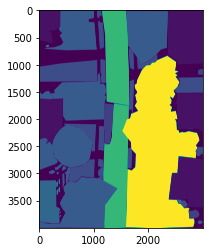

In [51]:
mask = Image.open('/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/train_masks/train_masks/10172.png')
a = transforms.ToTensor()(mask)
plt.imshow(a[0].numpy())

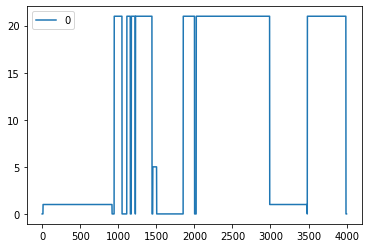

In [52]:
import pandas as pd
pd.DataFrame((a[0].numpy()*255)[:, 2500]).plot()

## Let's see how many classes are there

In [53]:
from collections import Counter
Counter((a[0].numpy()*255)[:, 2500])

Counter({0.0: 512, 1.0: 1399, 5.0: 51, 21.0: 2038})

# Now let's make the second trial, try epoch=70 with 256*256

In [54]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_data_path = '/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/train_images/train_images_resized'
train_mask_path = '/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/train_masks/train_masks_resized'
model_save_file_name = '/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/saved_model_and_loss'
model_name = 'Model_256_epochs70_batch_size10_lr000001_Jan17_for_report_second_try.pt'
mean_loss_file_name = model_save_file_name
loss_name = 'Mean_loss_256_epochs70_batch_size10_lr000001_Jan17_for_report_second_try.npy'

net = UNet(n_channels=3, n_classes=25)
net.to(device)
train_net(net,
          device, 
          train_data_path=train_data_path, 
          train_mask_path=train_mask_path, 
          model_save_file_name=model_save_file_name, 
          model_name=model_name, 
          mean_loss_file_name=mean_loss_file_name, 
          loss_name=loss_name, 
          epochs=70, 
          batch_size=10, 
          lr=0.0001)

Epoch  0 starts!


100%|██████████| 27/27 [00:10<00:00,  2.55it/s]


Epoch  1 starts!


100%|██████████| 27/27 [00:10<00:00,  2.58it/s]


Epoch  2 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  3 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  4 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  5 starts!


100%|██████████| 27/27 [00:10<00:00,  2.56it/s]


Epoch  6 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  7 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  8 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  9 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  10 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  11 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  12 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  13 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  14 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  15 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  16 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  17 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  18 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  19 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  20 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  21 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  22 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  23 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  24 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  25 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  26 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  27 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  28 starts!


100%|██████████| 27/27 [00:10<00:00,  2.56it/s]


Epoch  29 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  30 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  31 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  32 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  33 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  34 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  35 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  36 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  37 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  38 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  39 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  40 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  41 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  42 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  43 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  44 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  45 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  46 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  47 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  48 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  49 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  50 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  51 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  52 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  53 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  54 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  55 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  56 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  57 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  58 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  59 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  60 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  61 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  62 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  63 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  64 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  65 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  66 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  67 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  68 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Epoch  69 starts!


100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


path already there!
model saved successfully!
path already there!
mean loss saved successfully!


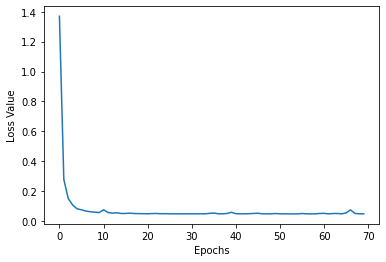

In [55]:
# 现在读取一下刚跑完的模型的loss看看图像如何
model_save_file_name = '/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/saved_model_and_loss'
loss_name = 'Mean_loss_256_epochs70_batch_size10_lr000001_Jan17_for_report_second_try.npy'
epoch_train_loss_filename = model_save_file_name + '/' + loss_name

train_data_mean_loss = np.load(epoch_train_loss_filename)
plt.plot(train_data_mean_loss, label ='Train Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.show()

## Make prediction

In [56]:
# This gives the submission result:
Model_256_epochs70_batch_size10_lr000001_Jan17_for_report_second_try = UNet(n_channels=3, n_classes=25)
Model_256_epochs70_batch_size10_lr000001_Jan17_for_report_second_try.to(device)
Model_256_epochs70_batch_size10_lr000001_Jan17_for_report_second_try.load_state_dict(torch.load('/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/saved_model_and_loss/Model_256_epochs70_batch_size10_lr000001_Jan17_for_report_second_try.pt'))
# 调用test数据
test_data_path = '/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/test_images/test_images'
test_path = glob.glob(os.path.join(test_data_path, '*.jpg'))

In [57]:
test_data_path = '/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/test_images/test_images_resized'
test_path_for_pred = glob.glob(os.path.join(test_data_path, '*.jpg'))

model_save_dir = '/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/test_images/pred_small_test_images_Jan17_for_report_256_epoch70_batch10_second_try'
create_dir_not_exist(model_save_dir)

pred_on_test(Model_256_epochs70_batch_size10_lr000001_Jan17_for_report_second_try, test_path_for_pred, model_save_dir=model_save_dir)

path created!


100%|██████████| 112/112 [00:03<00:00, 33.10it/s]


Saved Successfully!


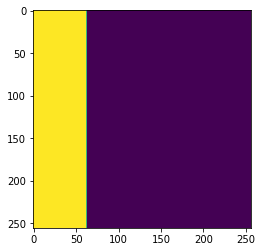

In [58]:
# 现在看一下预测出来的图片
dir = '/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/test_images/pred_small_test_images_Jan17_for_report_256_epoch70_batch10_second_try'
imgs_path = glob.glob(os.path.join(dir, '*.png'))
mask = Image.open(imgs_path[0])
a = transforms.ToTensor()(mask)
plt.imshow(a[0].numpy())

## Resize back and see the submission result

In [59]:
test_file = '/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/test_images/pred_small_test_images_Jan17_for_report_256_epoch70_batch10_second_try'
original_file = '/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/test_images/test_images'

# 为了保存新图
create_dir_not_exist('/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/test_images/pred_small_test_images_resized_back_Jan_17_second_try')
save_dir = '/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/test_images/pred_small_test_images_resized_back_Jan_17_second_try'


test_files = glob.glob(os.path.join(test_file, '*.png'))
original_files = glob.glob(os.path.join(original_file, '*.jpg'))

for i in tqdm(range(len(test_files))):
    resize_back(test_files[i], original_files[i], save_dir=save_dir, show_image=False)

path created!


100%|██████████| 112/112 [00:57<00:00,  1.95it/s]


In [20]:
# Submission.py
def rle_encode(img):
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

def create_rles(dir, submission_file_no):
    # 这个dir是你放resized back test images的地方！
    # create_dir_not_exist(dir)
    # dir = '/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/test_images/pred_small_test_images_resized_back/'
    dir = dir + '/'
    N = len(list(os.listdir(dir)))
    file_name = 'submission_file_' + str(submission_file_no) + '.csv'

    with open(file_name, 'w') as f:
        f.write('ImageClassId,rle_mask\n')
        for index, i in tqdm(enumerate(os.listdir(dir))):
            # print('{}/{}'.format(index, N))

            mask = Image.open(dir + i)
            mask = mask.resize((1024, 1024), resample=Image.NEAREST)
            mask = np.array(mask)

            for x in range(1, 25):
                enc = rle_encode(mask == x)
                f.write(f"{i.split('_')[0]}_{x},{enc}\n")

In [62]:
create_rles('/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/test_images/pred_small_test_images_resized_back_Jan_17_second_try', 'Jan17_256_epoch70_batch10_for_report')

112it [00:37,  2.96it/s]


Now this time, the submission file has a submission score of: 0.64618, which is an increase! 

# Now let's try to resize the training dataset to 512*512

We find it's the problem of resizing the training images. Therefore, I decide to redefine the resize function to make the training images have a width of the smaller value between width and height.

## Redefine the resize function

In [21]:
# 由于图片不是正方形，所以先把图片做成正方形。
def Square_Generated_and_saved(read_file, target_file_copy=False, colorful=True, show_image=False, size_=512): 
    # 这个不需要直接传tensor格式！

    image = Image.open(read_file)
    w, h = image.size
    # print(w,h)

    if colorful:
        new_image = Image.new('RGB', size=(min(w, h), min(w, h)), color= 'white')
    else:
        new_image = Image.new('L', size=(min(w, h), min(w, h)), color= 'white')

    new_image.paste(image)
    new_image=new_image.resize((size_, size_)) # 这个如果之后太慢的话再加

    if target_file_copy:
        # 提取文件名字
        image_name = read_file.split('/')[-1]
        target_file_copy = target_file_copy + '/' + image_name
        new_image.save(target_file_copy)

    if show_image:
        return new_image # 不是tensor格式！需要再用image_to_tensor！
    else:
        return None

## Resize the training data and mask data to 512*512

In [64]:
# It's not necessary to excecute this block every time!

# Firstly let's reshape every image we have and store them in another file
import glob
import os
from tqdm import tqdm

# 为每一次重新resize的图保存到一个file里！
new_file_path_train_data = '/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/train_images/train_images_resized_512_Jan_17for_report'
new_file_path_train_label = '/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/train_masks/train_masks_resized_512_Jan_17for_report'
create_dir_not_exist(new_file_path_train_data)
create_dir_not_exist(new_file_path_train_label)

train_data_path = '/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/train_images/train_images'
train_mask_path = '/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/train_masks/train_masks'

imgs_path = glob.glob(os.path.join(train_data_path, '*.jpg'))
mask_path = glob.glob(os.path.join(train_mask_path, '*.png'))

for image_file in tqdm(imgs_path):
    Square_Generated_and_saved(image_file, new_file_path_train_data, colorful=True, show_image=False, size_=512)
for image_file in tqdm(mask_path):
    Square_Generated_and_saved(image_file, new_file_path_train_label, colorful=False, show_image=False, size_=512)

path created!
path created!


100%|██████████| 261/261 [01:38<00:00,  2.64it/s]


## Do the same thing to test images

In [65]:
# 将test也做成相同格式

test_data_path = '/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/test_images/test_images'
test_path = glob.glob(os.path.join(test_data_path, '*.jpg'))

# 我们得把test image resize成512再说
# 先创建文件
def make_test_image_resized(necessary=False):
    if necessary:
        create_dir_not_exist('/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/test_images/test_images_resized_512_Jan17_for_report')
        test_data_path = '/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/test_images/test_images_resized_512_Jan17_for_report'
        test_path_for_pred = glob.glob(os.path.join(test_data_path, '*.jpg'))

        for test_ in tqdm(test_path):
            Square_Generated_and_saved(test_, target_file_copy=test_data_path, colorful=True, show_image=False, size_=512)
    else:
        print('Nothing is excecuted since the test images are already resized!')
  
make_test_image_resized(necessary=True)

path created!


100%|██████████| 112/112 [00:39<00:00,  2.82it/s]


## Have a look at one of the images

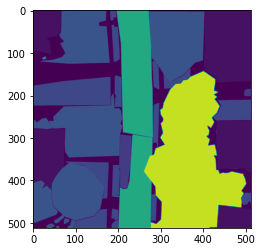

In [66]:
mask = Image.open('/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/train_masks/train_masks_resized_512_Jan_17for_report/10172.png')
a = transforms.ToTensor()(mask)
plt.imshow(a[0].numpy())

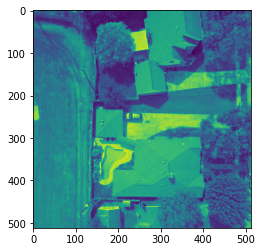

In [71]:
mask = Image.open('/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/test_images/test_images_resized_512_Jan17_for_report/10170.jpg')
a = transforms.ToTensor()(mask)
plt.imshow(a[0].numpy())

## Begin training: epochs=40, learning rate=0.0001

In [73]:
# 现在进行训练！
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_data_path = '/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/train_images/train_images_resized_512_Jan_17for_report'
train_mask_path = '/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/train_masks/train_masks_resized_512_Jan_17for_report'
model_save_file_name = '/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/saved_model_and_loss'
model_name = 'Model_512_epochs40_batch_size5_lr00001_Jan17_for_report_third_try.pt'
mean_loss_file_name = model_save_file_name
loss_name = 'Mean_loss_512_epochs40_batch_size5_lr00001_Jan17_for_report_third_try.npy'

net = UNet(n_channels=3, n_classes=25)
net.to(device)
train_net(net,
          device, 
          train_data_path=train_data_path, 
          train_mask_path=train_mask_path, 
          model_save_file_name=model_save_file_name, 
          model_name=model_name, 
          mean_loss_file_name=mean_loss_file_name, 
          loss_name=loss_name, 
          epochs=40, 
          batch_size=5, 
          lr=0.0001)

Epoch  0 starts!


100%|██████████| 53/53 [00:38<00:00,  1.37it/s]


Epoch  1 starts!


100%|██████████| 53/53 [00:38<00:00,  1.37it/s]


Epoch  2 starts!


100%|██████████| 53/53 [00:38<00:00,  1.37it/s]


Epoch  3 starts!


100%|██████████| 53/53 [00:38<00:00,  1.37it/s]


Epoch  4 starts!


100%|██████████| 53/53 [00:38<00:00,  1.37it/s]


Epoch  5 starts!


100%|██████████| 53/53 [00:38<00:00,  1.37it/s]


Epoch  6 starts!


100%|██████████| 53/53 [00:38<00:00,  1.37it/s]


Epoch  7 starts!


100%|██████████| 53/53 [00:38<00:00,  1.37it/s]


Epoch  8 starts!


100%|██████████| 53/53 [00:38<00:00,  1.37it/s]


Epoch  9 starts!


100%|██████████| 53/53 [00:38<00:00,  1.37it/s]


Epoch  10 starts!


100%|██████████| 53/53 [00:38<00:00,  1.37it/s]


Epoch  11 starts!


100%|██████████| 53/53 [00:38<00:00,  1.37it/s]


Epoch  12 starts!


100%|██████████| 53/53 [00:38<00:00,  1.37it/s]


Epoch  13 starts!


100%|██████████| 53/53 [00:38<00:00,  1.37it/s]


Epoch  14 starts!


100%|██████████| 53/53 [00:38<00:00,  1.37it/s]


Epoch  15 starts!


100%|██████████| 53/53 [00:38<00:00,  1.37it/s]


Epoch  16 starts!


100%|██████████| 53/53 [00:38<00:00,  1.37it/s]


Epoch  17 starts!


100%|██████████| 53/53 [00:38<00:00,  1.37it/s]


Epoch  18 starts!


100%|██████████| 53/53 [00:38<00:00,  1.37it/s]


Epoch  19 starts!


100%|██████████| 53/53 [00:38<00:00,  1.37it/s]


Epoch  20 starts!


100%|██████████| 53/53 [00:38<00:00,  1.37it/s]


Epoch  21 starts!


100%|██████████| 53/53 [00:38<00:00,  1.37it/s]


Epoch  22 starts!


100%|██████████| 53/53 [00:38<00:00,  1.37it/s]


Epoch  23 starts!


100%|██████████| 53/53 [00:38<00:00,  1.38it/s]


Epoch  24 starts!


100%|██████████| 53/53 [00:38<00:00,  1.37it/s]


Epoch  25 starts!


100%|██████████| 53/53 [00:38<00:00,  1.37it/s]


Epoch  26 starts!


100%|██████████| 53/53 [00:38<00:00,  1.37it/s]


Epoch  27 starts!


100%|██████████| 53/53 [00:38<00:00,  1.37it/s]


Epoch  28 starts!


100%|██████████| 53/53 [00:38<00:00,  1.38it/s]


Epoch  29 starts!


100%|██████████| 53/53 [00:38<00:00,  1.37it/s]


Epoch  30 starts!


100%|██████████| 53/53 [00:38<00:00,  1.37it/s]


Epoch  31 starts!


100%|██████████| 53/53 [00:38<00:00,  1.37it/s]


Epoch  32 starts!


100%|██████████| 53/53 [00:38<00:00,  1.37it/s]


Epoch  33 starts!


100%|██████████| 53/53 [00:38<00:00,  1.37it/s]


Epoch  34 starts!


100%|██████████| 53/53 [00:38<00:00,  1.37it/s]


Epoch  35 starts!


100%|██████████| 53/53 [00:38<00:00,  1.37it/s]


Epoch  36 starts!


100%|██████████| 53/53 [00:38<00:00,  1.37it/s]


Epoch  37 starts!


100%|██████████| 53/53 [00:38<00:00,  1.37it/s]


Epoch  38 starts!


100%|██████████| 53/53 [00:38<00:00,  1.37it/s]


Epoch  39 starts!


100%|██████████| 53/53 [00:38<00:00,  1.37it/s]


path already there!
model saved successfully!
path already there!
mean loss saved successfully!


## Plot the loss function value curve

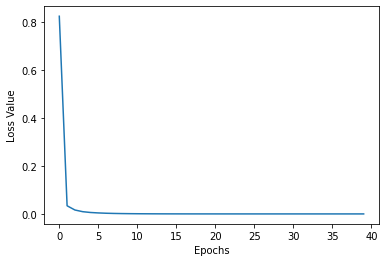

In [74]:
# 现在读取一下刚跑完的模型的loss看看图像如何
model_save_file_name = '/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/saved_model_and_loss'
loss_name = 'Mean_loss_512_epochs40_batch_size5_lr00001_Jan17_for_report_third_try.npy'
epoch_train_loss_filename = model_save_file_name + '/' + loss_name

train_data_mean_loss = np.load(epoch_train_loss_filename)
plt.plot(train_data_mean_loss, label ='Train Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.show()

## Now we begin to predict

In [22]:
# 现在开始预测
def pred_on_test(model, test_path_for_pred, model_save_dir): # 这两个参数都是文件夹位置，我们的目的是将新的图片保存下来！（不是保存tensor）

    for small_test_data in tqdm(test_path_for_pred):
        image = cv2.imread(small_test_data)

        if image.max() > 1:
            image = image / 255
        image = torch.tensor(image)
        image = image.permute(2, 0, 1)
        image = image.to(device=device, dtype=torch.float32)
        image = image.unsqueeze(0)

        model.eval()
        outputs = model(image) # 格式是tensor，大小是[1, 25, 256, 256]
        outputs = torch.argmax(outputs, 1) # 现在是[1, 256, 256]

        # ---------------------Save the Predicted Images------------------
        image_name = small_test_data.split('/')[-1].split('.')[0]
        destination_dir = model_save_dir + '/' + image_name + '.png'
        outputs = outputs.long()

        if outputs.max() < 1:
            outputs = outputs.float()*255.0
        else:
            outputs = outputs.float()

        # outputs = outputs.float()
        save_image(outputs, destination_dir)  # outputs大小是[1, 256, 256]
        # save_image(torch.from_numpy(image_temp0).float()/255.0, './temp/0image_'+str(index_temp)+'.jpg', nrow= 1)

    print()
    print('Saved Successfully!')

In [76]:
# This gives the submission result:
# Read the model
Model_512_epochs40_batch_size5_lr00001_Jan17_for_report_third_try = UNet(n_channels=3, n_classes=25)
Model_512_epochs40_batch_size5_lr00001_Jan17_for_report_third_try.to(device)
Model_512_epochs40_batch_size5_lr00001_Jan17_for_report_third_try.load_state_dict(torch.load('/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/saved_model_and_loss/Model_512_epochs40_batch_size5_lr00001_Jan17_for_report_third_try.pt'))

# 调用test数据
test_data_path = '/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/test_images/test_images'
test_path = glob.glob(os.path.join(test_data_path, '*.jpg'))

In [78]:
test_data_path = '/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/test_images/test_images_resized_512_Jan17_for_report'
test_path_for_pred = glob.glob(os.path.join(test_data_path, '*.jpg'))

model_save_dir = '/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/test_images/pred_small_test_images_512_Kan17_for_report_third_try'
create_dir_not_exist(model_save_dir)

pred_on_test(Model_512_epochs40_batch_size5_lr00001_Jan17_for_report_third_try, test_path_for_pred, model_save_dir=model_save_dir)

path already there!


100%|██████████| 112/112 [00:08<00:00, 12.84it/s]


Saved Successfully!


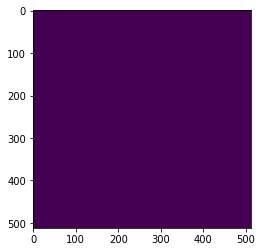

In [79]:
# Let's see the predicted image
dir = '/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/test_images/pred_small_test_images_512_Kan17_for_report_third_try'
imgs_path = glob.glob(os.path.join(dir, '*.png'))
mask = Image.open(imgs_path[0])
a = transforms.ToTensor()(mask)
plt.imshow(a[0].numpy())

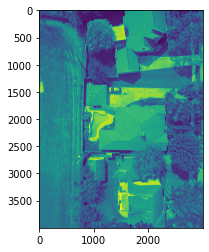

In [80]:
# 对比原test图
dir = '/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/test_images/test_images'
imgs_path = glob.glob(os.path.join(dir, '*.jpg'))
mask = Image.open(imgs_path[0])
a = transforms.ToTensor()(mask)
plt.imshow(a[0].numpy())

## Make a submission

In [82]:
create_rles('/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/test_images/pred_small_test_images_512_Kan17_for_report_third_try', 'Model_512_Kan17_for_report_third_try_66')

112it [00:24,  4.66it/s]


This submission.csv has a score of: 0.66108, and we should do more to increase this.

# Seems the epochs are too many, now we try epochs=10, learning rate=0.0001

In [96]:
# Empty the cache
torch.cuda.empty_cache()

In [23]:
# 现在进行训练！
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_data_path = '/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/train_images/train_images_resized_512_Jan_17for_report'
train_mask_path = '/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/train_masks/train_masks_resized_512_Jan_17for_report'
model_save_file_name = '/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/saved_model_and_loss'
model_name = 'Model_512_epochs10_batch_size10_lr00001_Jan17_for_report_fourth_try_final.pt'
mean_loss_file_name = model_save_file_name
loss_name = 'Mean_loss_512_epochs10_batch_size10_lr00001_Jan17_for_report_fourth_try_final.npy'

net = UNet(n_channels=3, n_classes=25)
net.to(device)
train_net(net,
          device, 
          train_data_path=train_data_path, 
          train_mask_path=train_mask_path, 
          model_save_file_name=model_save_file_name, 
          model_name=model_name, 
          mean_loss_file_name=mean_loss_file_name, 
          loss_name=loss_name, 
          epochs=10, 
          batch_size=1, 
          lr=0.0001)

Epoch  0 starts!


100%|██████████| 261/261 [01:11<00:00,  3.65it/s]


Epoch  1 starts!


100%|██████████| 261/261 [00:43<00:00,  6.06it/s]


Epoch  2 starts!


100%|██████████| 261/261 [00:43<00:00,  6.06it/s]


Epoch  3 starts!


100%|██████████| 261/261 [00:43<00:00,  6.06it/s]


Epoch  4 starts!


100%|██████████| 261/261 [00:43<00:00,  6.06it/s]


Epoch  5 starts!


100%|██████████| 261/261 [00:43<00:00,  6.06it/s]


Epoch  6 starts!


100%|██████████| 261/261 [00:43<00:00,  6.06it/s]


Epoch  7 starts!


100%|██████████| 261/261 [00:43<00:00,  6.06it/s]


Epoch  8 starts!


100%|██████████| 261/261 [00:43<00:00,  6.06it/s]


Epoch  9 starts!


100%|██████████| 261/261 [00:43<00:00,  6.06it/s]


path already there!
model saved successfully!
path already there!
mean loss saved successfully!


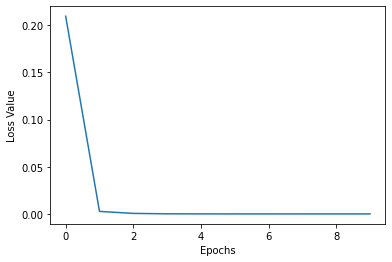

In [25]:
# 现在读取一下刚跑完的模型的loss看看图像如何
model_save_file_name = '/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/saved_model_and_loss'
loss_name = 'Mean_loss_512_epochs10_batch_size10_lr00001_Jan17_for_report_fourth_try_final.npy'
epoch_train_loss_filename = model_save_file_name + '/' + loss_name

train_data_mean_loss = np.load(epoch_train_loss_filename)
plt.plot(train_data_mean_loss, label ='Train Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.show()

## Make prediction

In [27]:
# This gives the submission result:
# 先读取模型
Model_512_epochs10_batch_size10_lr00001_Jan17_for_report_fourth_try = UNet(n_channels=3, n_classes=25)
Model_512_epochs10_batch_size10_lr00001_Jan17_for_report_fourth_try.to(device)
Model_512_epochs10_batch_size10_lr00001_Jan17_for_report_fourth_try.load_state_dict(torch.load('/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/saved_model_and_loss/Model_512_epochs10_batch_size10_lr00001_Jan17_for_report_fourth_try_final.pt'))

# 调用test数据
test_data_path = '/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/test_images/test_images'
test_path = glob.glob(os.path.join(test_data_path, '*.jpg'))

In [28]:
test_data_path = '/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/test_images/test_images_resized_512_Jan17_for_report'
test_path_for_pred = glob.glob(os.path.join(test_data_path, '*.jpg'))

model_save_dir = '/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/test_images/pred_small_test_images_512_lr0001_epoch10_Jan_17_for_report_fourth_try'
create_dir_not_exist(model_save_dir)

pred_on_test(Model_512_epochs10_batch_size10_lr00001_Jan17_for_report_fourth_try, test_path_for_pred, model_save_dir=model_save_dir)

path created!


100%|██████████| 112/112 [00:09<00:00, 11.86it/s]


Saved Successfully!


## Now let's run the submission.py

In [29]:
create_rles('/content/drive/MyDrive/DSBA M2/Deep Learning/DL的kaggle/data/test_images/pred_small_test_images_512_lr0001_epoch10_Jan_17_for_report_fourth_try', 'Model_512_lr0001_epoch10_Jan_17_for_report_fourth_try')

112it [00:23,  4.81it/s]


The submission score is: 0.66770, which is the highest one so far.